# <font color = 'tomato'>Hyperspectral Image Analysis - Classification</font>

## Import Libraries

In [1]:
import tensorflow as tf

In [2]:
# import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
sn.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Read Data

In [46]:
from scipy.io import loadmat

def read_HSI():
    X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


### Visualize Bands

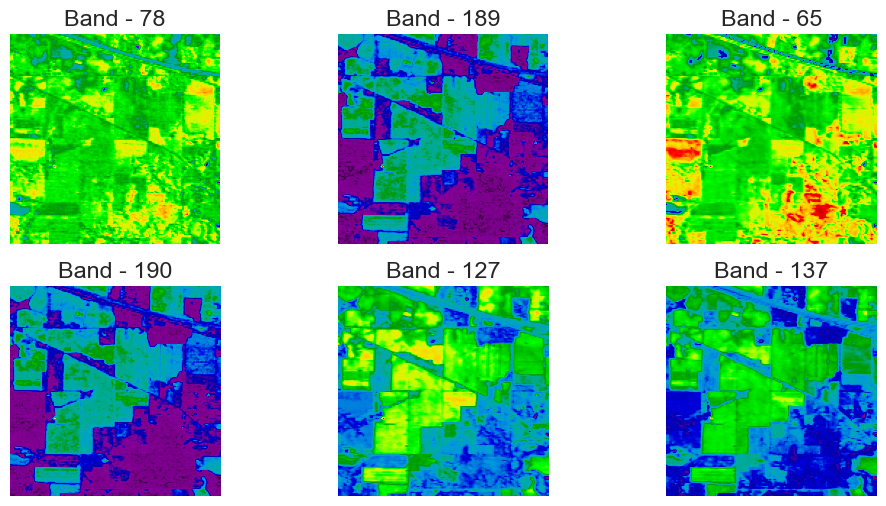

In [47]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

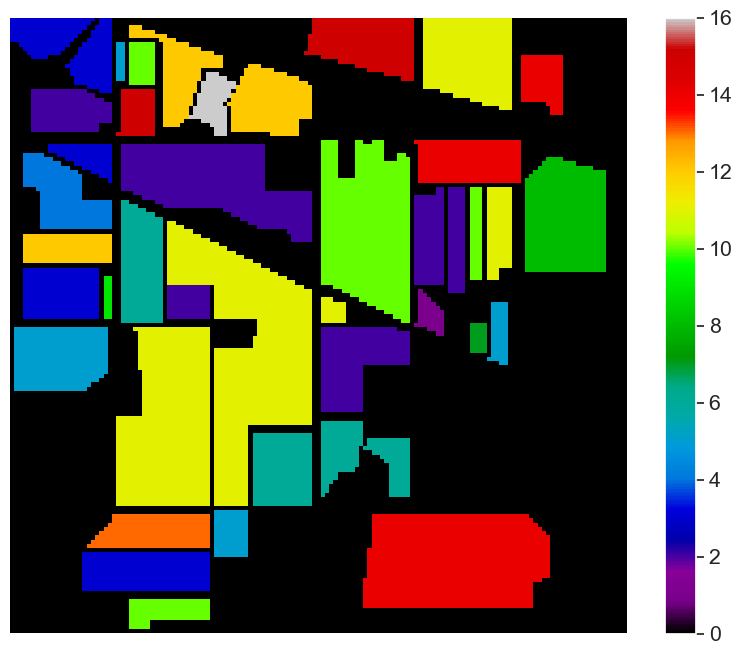

In [48]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [49]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [50]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21025 entries, 0 to 21024
Columns: 201 entries, band1 to class
dtypes: uint16(200), uint8(1)
memory usage: 8.0 MB


In [52]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200
count,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,...,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000
mean,2957.363472,4091.321237,4277.502259,4169.956671,4516.678668,4790.595149,4848.317574,4714.732509,4668.904828,4439.065541,...,1079.310773,1061.927848,1060.210273,1063.276813,1050.048514,1040.201141,1043.370321,1030.194816,1015.571463,1008.513579
std,354.918708,230.390005,257.827640,280.761254,346.035984,414.382138,469.247667,491.728349,533.232855,539.908195,...,49.943791,38.843805,38.712195,41.920969,34.242725,26.452672,29.794418,20.865106,11.386402,7.050921
min,2560.000000,2709.000000,3649.000000,2810.000000,3840.000000,4056.000000,4004.000000,3865.000000,3775.000000,2792.000000,...,998.000000,998.000000,999.000000,999.000000,993.000000,990.000000,992.000000,989.000000,986.000000,981.000000
25%,2602.000000,3889.000000,4066.000000,3954.000000,4214.000000,4425.000000,4421.000000,4263.000000,4173.000000,3940.000000,...,1031.000000,1026.000000,1024.000000,1024.000000,1019.000000,1016.000000,1016.000000,1012.000000,1006.000000,1004.000000
50%,2780.000000,4106.000000,4237.000000,4126.000000,4478.000000,4754.000000,4808.000000,4666.000000,4632.000000,4404.000000,...,1068.000000,1053.000000,1052.000000,1054.000000,1043.000000,1033.000000,1035.000000,1026.000000,1014.000000,1009.000000
75%,3179.000000,4247.000000,4479.000000,4350.000000,4772.000000,5093.000000,5198.000000,5100.000000,5084.000000,4860.000000,...,1129.000000,1099.000000,1098.000000,1104.000000,1083.000000,1066.000000,1072.000000,1050.000000,1024.000000,1014.000000
max,4536.000000,5744.000000,6361.000000,6362.000000,7153.000000,7980.000000,8284.000000,8128.000000,8194.000000,7928.000000,...,1364.000000,1287.000000,1289.000000,1315.000000,1258.000000,1201.000000,1245.000000,1167.000000,1076.000000,1036.000000


# Principal Component Analysis (PCA)


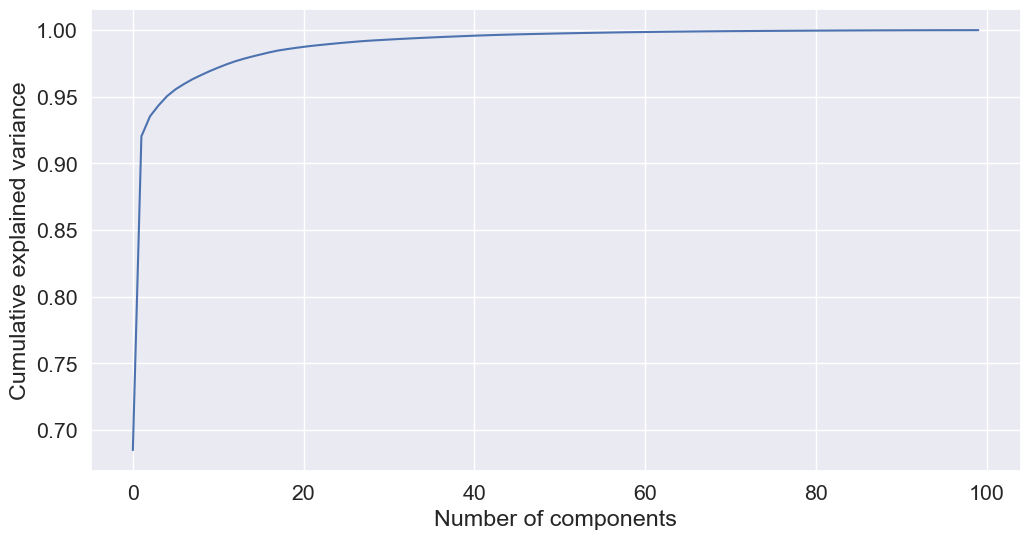

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()

In [54]:
pca = PCA(n_components = 150)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,151)]+['class']

In [55]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-142,PC-143,PC-144,PC-145,PC-146,PC-147,PC-148,PC-149,PC-150,class
0,5014.905985,1456.863260,72.697049,71.204926,-435.686985,-68.840318,134.809864,-304.372455,256.432994,-66.630999,...,-3.432344,-7.238062,-4.081369,-4.046728,-4.800225,0.275414,1.776964,-8.996627,-3.132469,3
1,5601.383743,-2023.450087,350.134661,-528.465053,148.088296,-288.359031,202.956863,240.848020,-474.857836,93.493771,...,-2.450115,-1.241687,-4.225156,1.632603,-1.621563,-9.340565,-0.487024,-3.290424,-2.077826,3
2,5796.135442,-3090.394852,490.539929,-760.214346,259.933303,-131.611181,172.927304,205.911237,572.491978,-191.622014,...,-4.648347,-4.425079,-4.835423,4.611153,-0.673975,-1.867074,-0.502016,-12.283085,3.449286,3
3,5586.204575,-2369.376085,356.274719,-502.687155,146.554951,-306.679326,251.071095,234.966433,-314.023248,54.962246,...,-6.747266,-4.514190,-9.167345,-0.080119,5.615159,9.972850,5.133110,-1.666689,5.452316,3
4,5020.990792,339.603390,-23.007525,-92.556769,-368.495443,-438.266709,502.715429,-345.536587,-188.352757,-67.506061,...,-7.620716,-3.023884,-15.550071,0.909380,9.147317,0.650075,0.929248,-3.449769,4.164550,3


### Display the bands after PCA

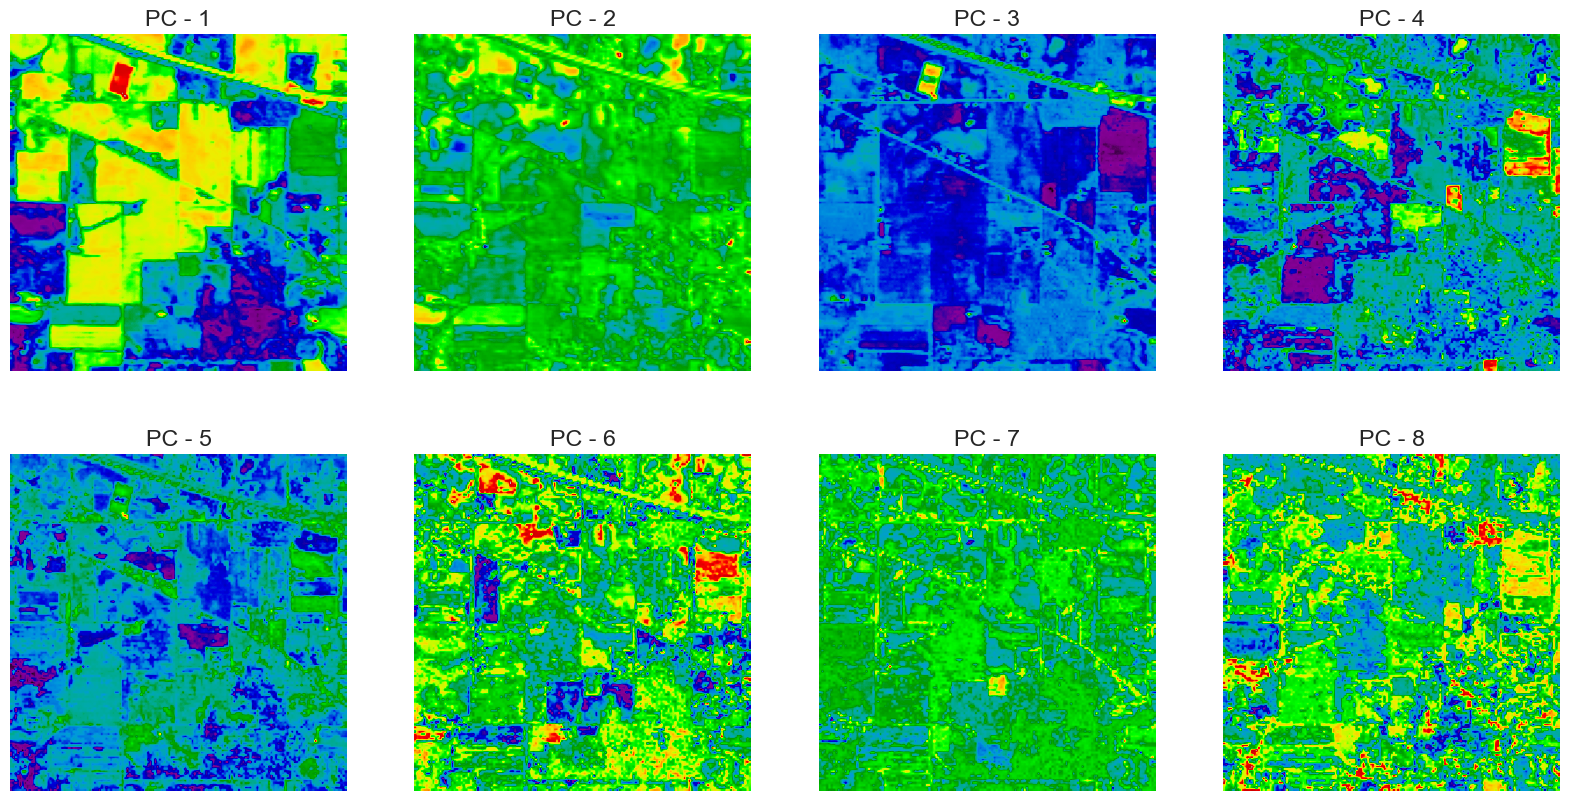

In [56]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'PC - {i}')

plt.savefig('IP_PCA_Bands.png')

In [58]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

In [59]:
X_train.shape

(8199, 150)

# Support Vector Machine (SVM)

In [61]:
X_train = X_train.reshape(8199, 150)
X_train.shape

(8199, 150)

In [62]:
from sklearn import svm

clf = svm.SVC(C=100, kernel='rbf')

clf.fit(X_train, y_train)

SVC(C=100)

In [63]:
y_pred = clf.predict(X_test)

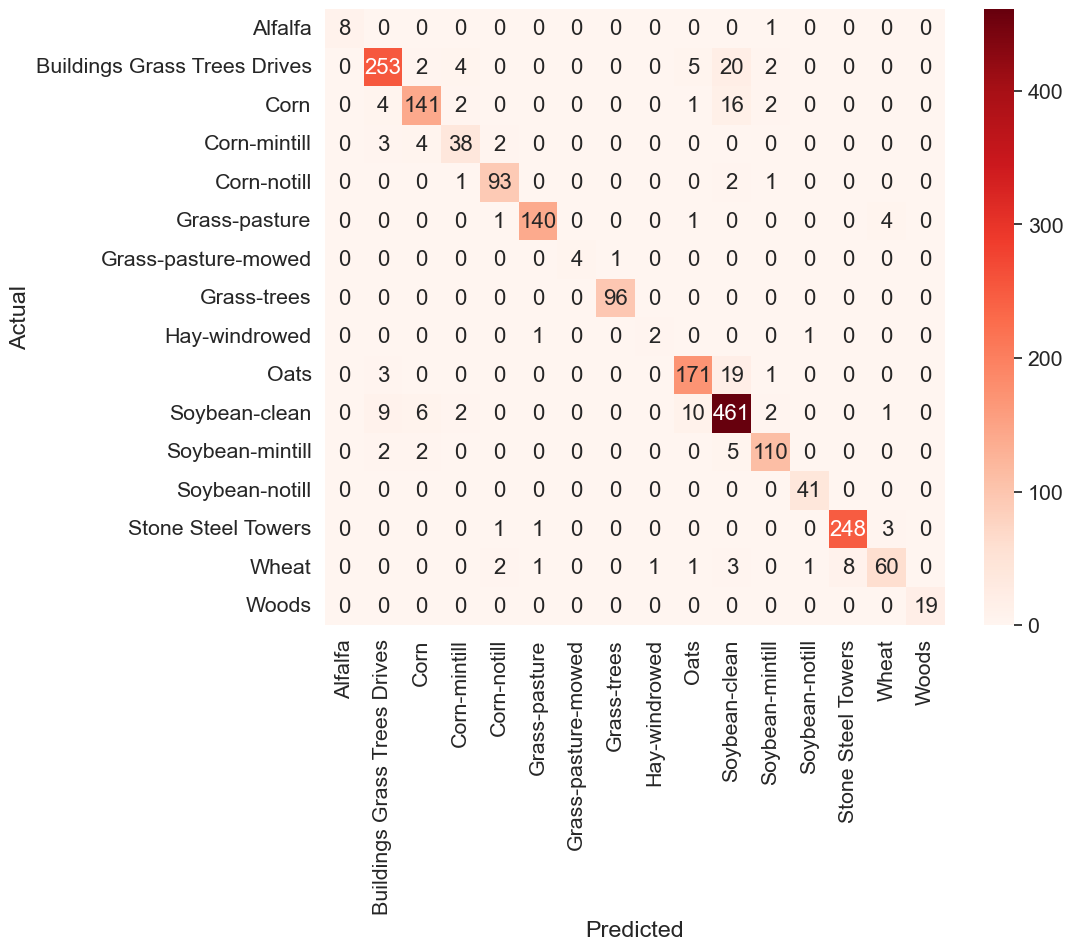

In [64]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [65]:
print(classification_report(y_test, y_pred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.92      0.88      0.90       286
                Corn-mintill       0.91      0.85      0.88       166
                        Corn       0.81      0.81      0.81        47
               Grass-pasture       0.94      0.96      0.95        97
                 Grass-trees       0.98      0.96      0.97       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.67      0.50      0.57         4
              Soybean-notill       0.90      0.88      0.89       194
             Soybean-mintill       0.88      0.94      0.91       491
               Soybean-clean       0.92      0.92      0.92       119
                       Wheat       0.95      1.00      0.98        41
                   

## Classification Map

In [66]:
l=[]
for i in range(q.shape[0]):
    if q.iloc[i, -1] == 0:
        l.append(0)
    else:
#         l.append(clf.predict(q.iloc[i, :-1].values.reshape(1, -1)))
        l.append(clf.predict(q.iloc[i, :-1].values.reshape(1, -1)))

# l = [np.argmax(l[i]) for i in range(len(l))]

C:\Users\ksara\AppData\Local\Temp\ipykernel_22060\3714146333.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clmap = np.array(l).reshape(145, 145).astype('float')


X shape: (145, 145, 200)
y shape: (145, 145)


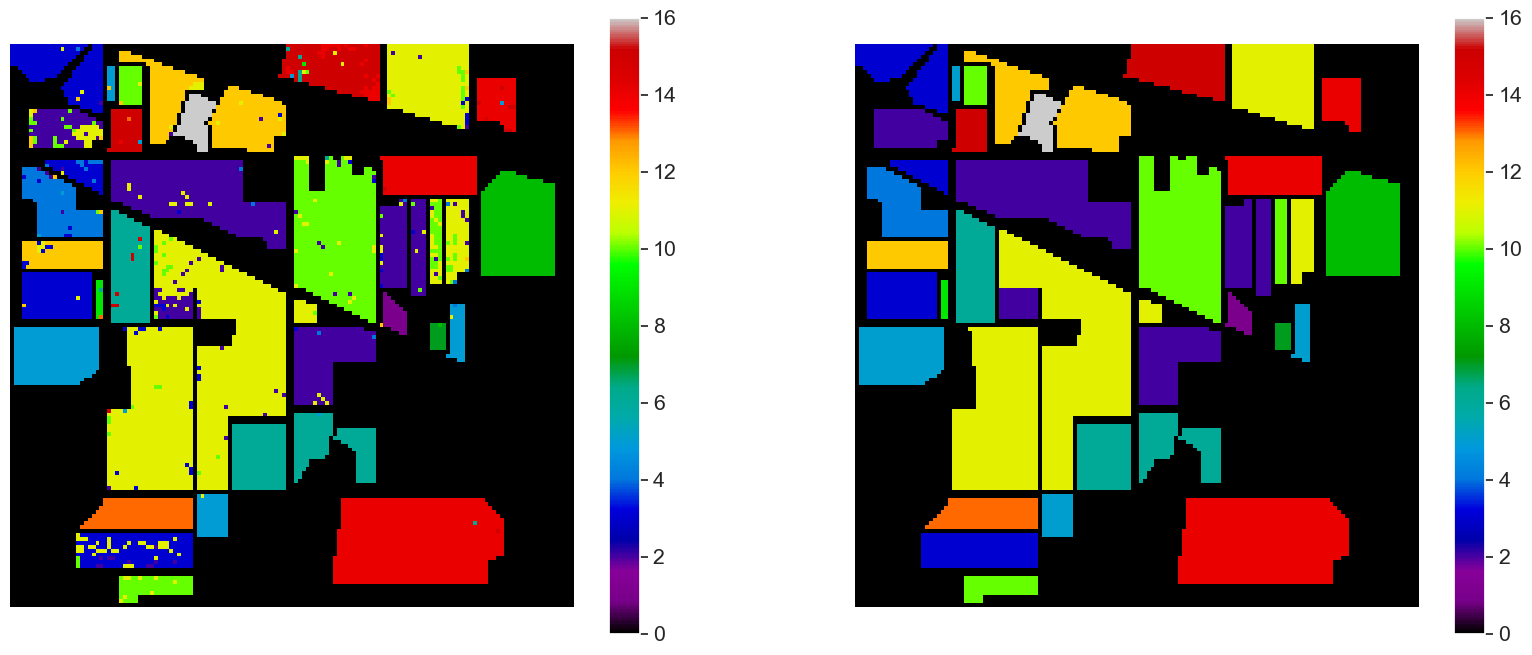

In [67]:
clmap = np.array(l).reshape(145, 145).astype('float')
X, y = read_HSI()

fig = plt.figure(figsize = (20, 8))

fig.add_subplot(1,2,1)
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

plt.show()

# Data Reset

In [85]:
q = df

x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

X_train=np.expand_dims(X_train,-1)

# Neural Network (ANN) / Multi Layer Perceptron (MLP)

In [86]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(200,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(17, activation='softmax')
])

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
              optimizer=tf.keras.optimizers.Adamax(), metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1024)              205824    
                                                                 
 dense_29 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_30 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dense_34 (Dense)            (None, 17)               

In [88]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
257/257 [==============================] - 2s 7ms/step - loss: 88.1178 - accuracy: 0.3114
Epoch 2/10
257/257 [==============================] - 2s 6ms/step - loss: 2.7676 - accuracy: 0.4507
Epoch 3/10
257/257 [==============================] - 2s 7ms/step - loss: 2.3829 - accuracy: 0.4788
Epoch 4/10
257/257 [==============================] - 2s 7ms/step - loss: 1.8488 - accuracy: 0.5141
Epoch 5/10
257/257 [==============================] - 2s 7ms/step - loss: 1.7505 - accuracy: 0.5237
Epoch 6/10
257/257 [==============================] - 2s 7ms/step - loss: 1.5968 - accuracy: 0.5269
Epoch 7/10
257/257 [==============================] - 2s 7ms/step - loss: 1.2765 - accuracy: 0.5752
Epoch 8/10
257/257 [==============================] - 2s 7ms/step - loss: 1.2861 - accuracy: 0.5667
Epoch 9/10
257/257 [==============================] - 2s 7ms/step - loss: 1.2901 - accuracy: 0.5669
Epoch 10/10
257/257 [==============================] - 2s 7ms/step - loss: 1.3849 - accuracy: 0.547

In [89]:
y_pred = model.predict(X_test)

65/65 [==============================] - 0s 2ms/step


In [90]:
y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

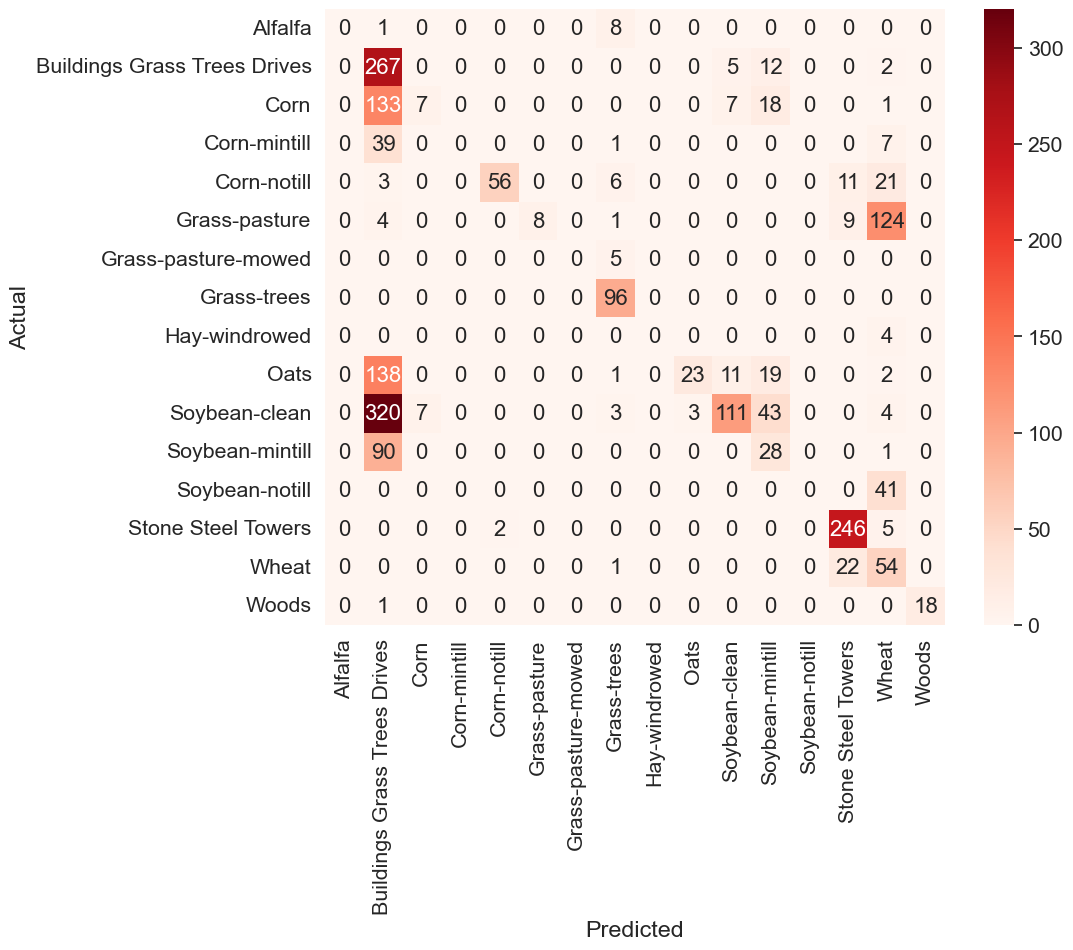

In [91]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [92]:
model.evaluate(X_test, y_test)

65/65 [==============================] - 0s 5ms/step - loss: 1.4715 - accuracy: 0.4459


[1.4715468883514404, 0.44585365056991577]

In [93]:
print(classification_report(y_test, y_pred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       0.00      0.00      0.00         9
                 Corn-notill       0.27      0.93      0.42       286
                Corn-mintill       0.50      0.04      0.08       166
                        Corn       0.00      0.00      0.00        47
               Grass-pasture       0.97      0.58      0.72        97
                 Grass-trees       1.00      0.05      0.10       146
         Grass-pasture-mowed       0.00      0.00      0.00         5
               Hay-windrowed       0.79      1.00      0.88        96
                        Oats       0.00      0.00      0.00         4
              Soybean-notill       0.88      0.12      0.21       194
             Soybean-mintill       0.83      0.23      0.36       491
               Soybean-clean       0.23      0.24      0.23       119
                       Wheat       0.00      0.00      0.00        41
                   

C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification Map

In [94]:
l=[]
for i in range(q.shape[0]):
    if q.iloc[i, -1] == 0:
        l.append(0)
    else:
        l.append(model.predict(q.iloc[i, :-1].values.reshape(1, -1), verbose=0))
#         l.append(model.predict(q.iloc[i, :-1].values.reshape(1, -1)))

l = [np.argmax(l[i]) for i in range(len(l))]

X shape: (145, 145, 200)
y shape: (145, 145)


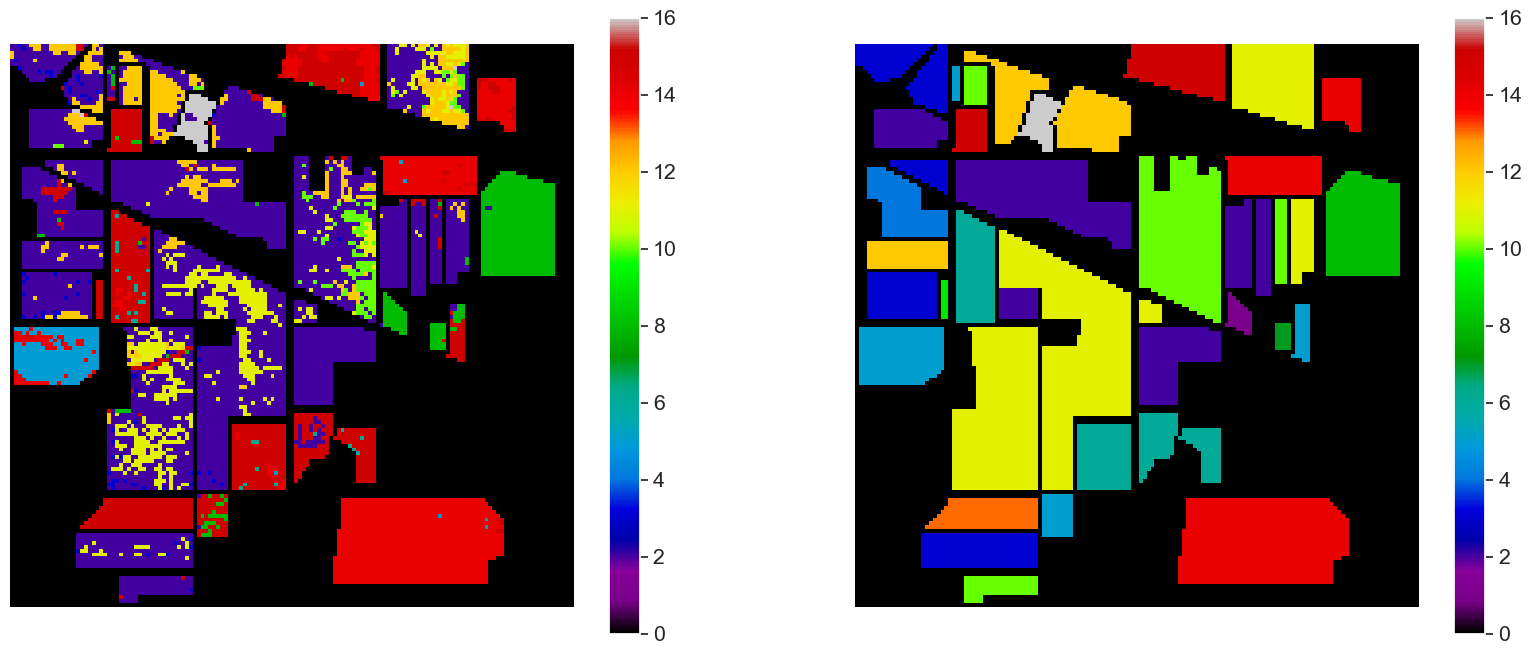

In [95]:
clmap = np.array(l).reshape(145, 145).astype('float')
X, y = read_HSI()

fig = plt.figure(figsize = (20, 8))

fig.add_subplot(1,2,1)
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

plt.show()

# Convolutional Neural Network (CNN)

In [96]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((200,1)),
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(512,5,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(1024,5,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(17, activation='softmax')
])

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
              optimizer=tf.keras.optimizers.Adamax(), metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 256)          1024      
                                                                 
 batch_normalization (BatchN  (None, 198, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 194, 512)          655872    
                                                                 
 batch_normalization_1 (Batc  (None, 194, 512)         2048      
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 190, 1024)         2622464   
                                                                 
 batch_normalization_2 (Batc  (None, 190, 1024)       

In [98]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
257/257 [==============================] - 26s 75ms/step - loss: 3.1750 - accuracy: 0.4305
Epoch 2/10
257/257 [==============================] - 19s 74ms/step - loss: 1.2968 - accuracy: 0.5162
Epoch 3/10
257/257 [==============================] - 19s 75ms/step - loss: 1.1932 - accuracy: 0.5507
Epoch 4/10
257/257 [==============================] - 20s 76ms/step - loss: 1.1315 - accuracy: 0.5774
Epoch 5/10
257/257 [==============================] - 20s 76ms/step - loss: 1.0863 - accuracy: 0.5903
Epoch 6/10
257/257 [==============================] - 20s 77ms/step - loss: 1.0272 - accuracy: 0.6129
Epoch 7/10
257/257 [==============================] - 20s 78ms/step - loss: 0.9984 - accuracy: 0.6254
Epoch 8/10
257/257 [==============================] - 20s 79ms/step - loss: 0.9168 - accuracy: 0.6476
Epoch 9/10
257/257 [==============================] - 21s 80ms/step - loss: 0.8836 - accuracy: 0.6650
Epoch 10/10
257/257 [==============================] - 21s 80ms/step - loss: 0.819

In [99]:
y_pred = model.predict(X_test)

65/65 [==============================] - 1s 16ms/step


In [100]:
y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

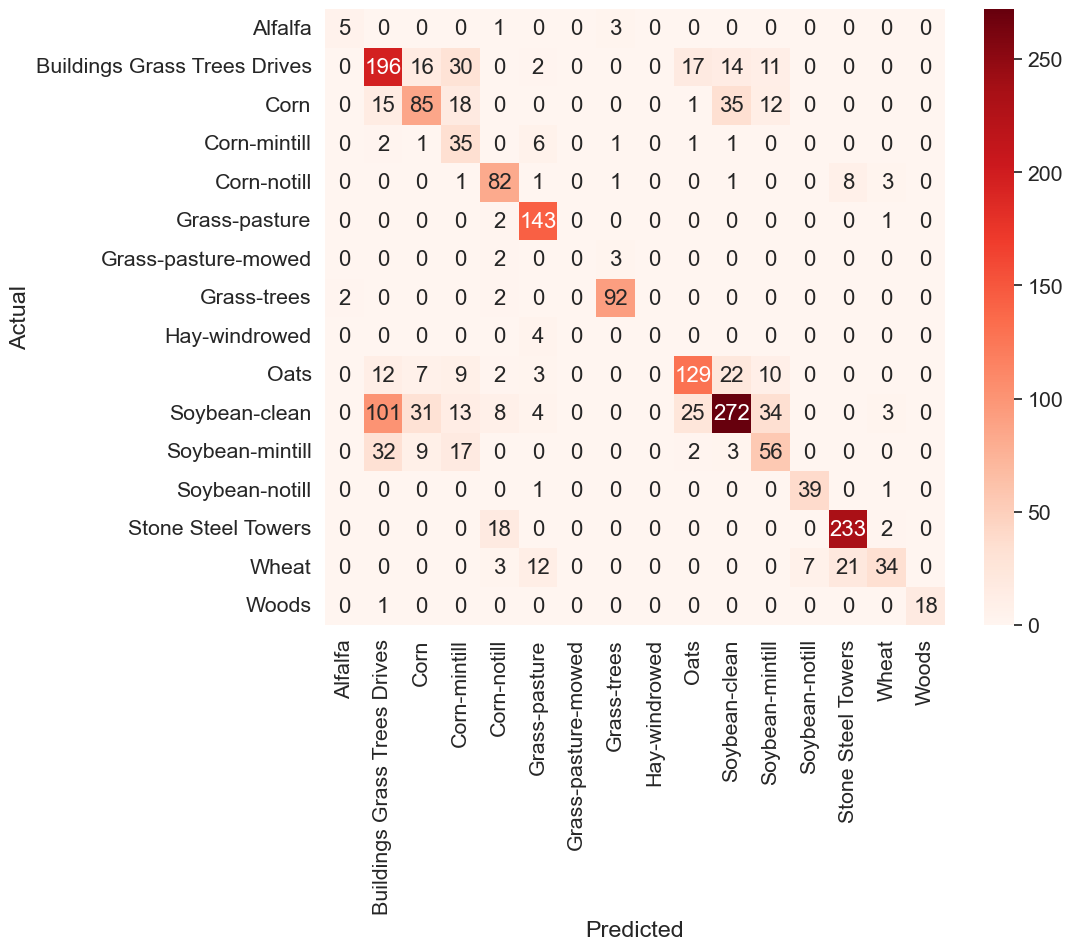

In [101]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [102]:
model.evaluate(X_test, y_test)

65/65 [==============================] - 2s 18ms/step - loss: 0.8697 - accuracy: 0.6922


[0.8697288632392883, 0.6921951174736023]

In [103]:
print(classification_report(y_test, y_pred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       0.71      0.56      0.63         9
                 Corn-notill       0.55      0.69      0.61       286
                Corn-mintill       0.57      0.51      0.54       166
                        Corn       0.28      0.74      0.41        47
               Grass-pasture       0.68      0.85      0.76        97
                 Grass-trees       0.81      0.98      0.89       146
         Grass-pasture-mowed       0.00      0.00      0.00         5
               Hay-windrowed       0.92      0.96      0.94        96
                        Oats       0.00      0.00      0.00         4
              Soybean-notill       0.74      0.66      0.70       194
             Soybean-mintill       0.78      0.55      0.65       491
               Soybean-clean       0.46      0.47      0.46       119
                       Wheat       0.85      0.95      0.90        41
                   

C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification Map

In [104]:
l=[]
for i in range(q.shape[0]):
    if q.iloc[i, -1] == 0:
        l.append(0)
    else:
        l.append(model.predict(q.iloc[i, :-1].values.reshape(1, -1), verbose=0))
#         l.append(model.predict(q.iloc[i, :-1].values.reshape(1, -1)))

l = [np.argmax(l[i]) for i in range(len(l))]

X shape: (145, 145, 200)
y shape: (145, 145)


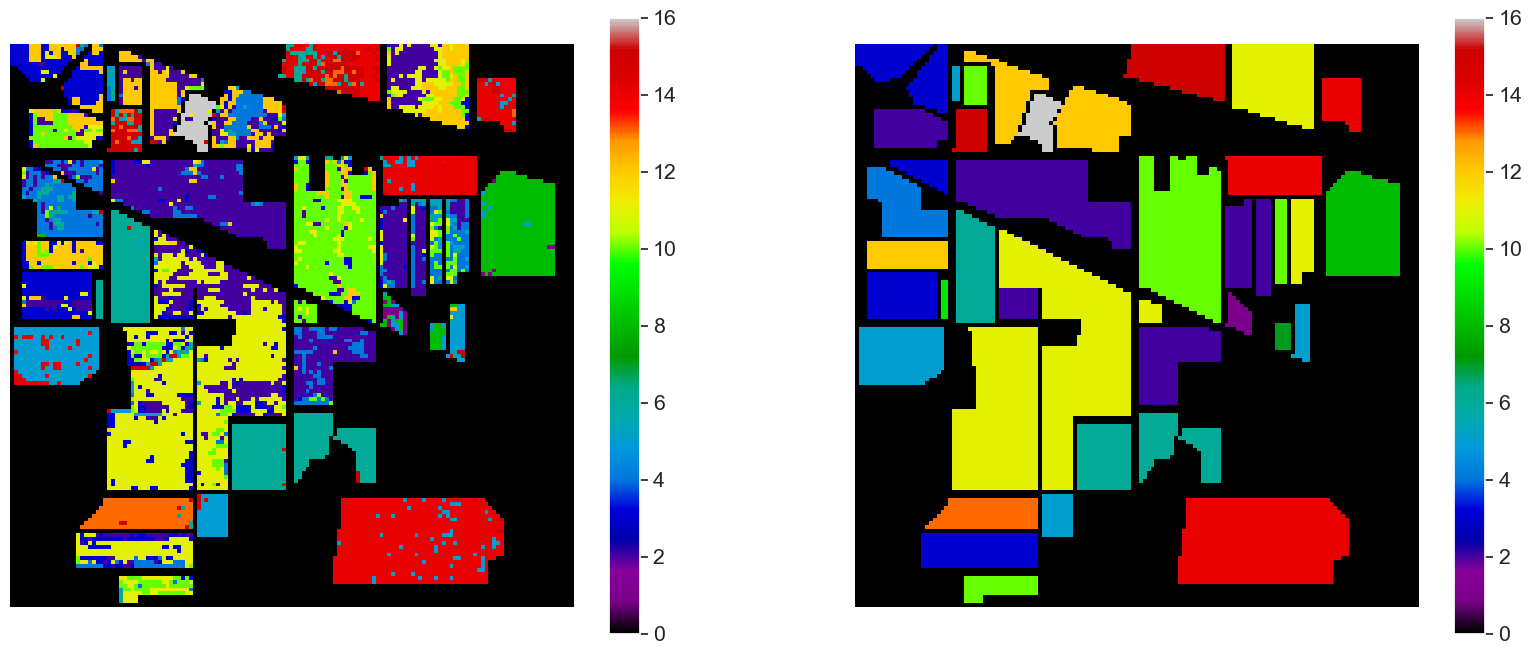

In [105]:
clmap = np.array(l).reshape(145, 145).astype('float')
X, y = read_HSI()

fig = plt.figure(figsize = (20, 8))

fig.add_subplot(1,2,1)
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

plt.show()

# Transformer Networks

In [106]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen,vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

vocab_size = 4000
maxlen = 200 
embed_dim = 32
num_heads = 4
ff_dim = 256

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block3 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)
x = transformer_block2(x)
x = transformer_block3(x)
x = layers.GlobalAveragePooling1D()(x)
# x = transformer_block(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(17, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          134400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 200, 32)          33600     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 200, 32)          33600     
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 200, 32)          33600 

In [107]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test)
)

Epoch 1/5
257/257 [==============================] - 15s 44ms/step - loss: 1.7481 - accuracy: 0.3957 - val_loss: 1.4732 - val_accuracy: 0.4400
Epoch 2/5
257/257 [==============================] - 11s 41ms/step - loss: 1.4250 - accuracy: 0.4658 - val_loss: 1.4079 - val_accuracy: 0.4688
Epoch 3/5
257/257 [==============================] - 11s 42ms/step - loss: 1.3425 - accuracy: 0.4836 - val_loss: 1.3723 - val_accuracy: 0.4634
Epoch 4/5
257/257 [==============================] - 11s 42ms/step - loss: 1.2471 - accuracy: 0.5226 - val_loss: 1.4126 - val_accuracy: 0.5015
Epoch 5/5
257/257 [==============================] - 11s 42ms/step - loss: 1.1505 - accuracy: 0.5624 - val_loss: 1.4040 - val_accuracy: 0.5039


In [108]:
model.evaluate(X_test, y_test)

65/65 [==============================] - 1s 18ms/step - loss: 1.4040 - accuracy: 0.5039


[1.4040007591247559, 0.5039024353027344]

In [109]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          134400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 200, 32)          33600     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 200, 32)          33600     
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 200, 32)          33600 

In [110]:
y_pred = model.predict(X_test)

65/65 [==============================] - 2s 17ms/step


In [111]:
y_pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

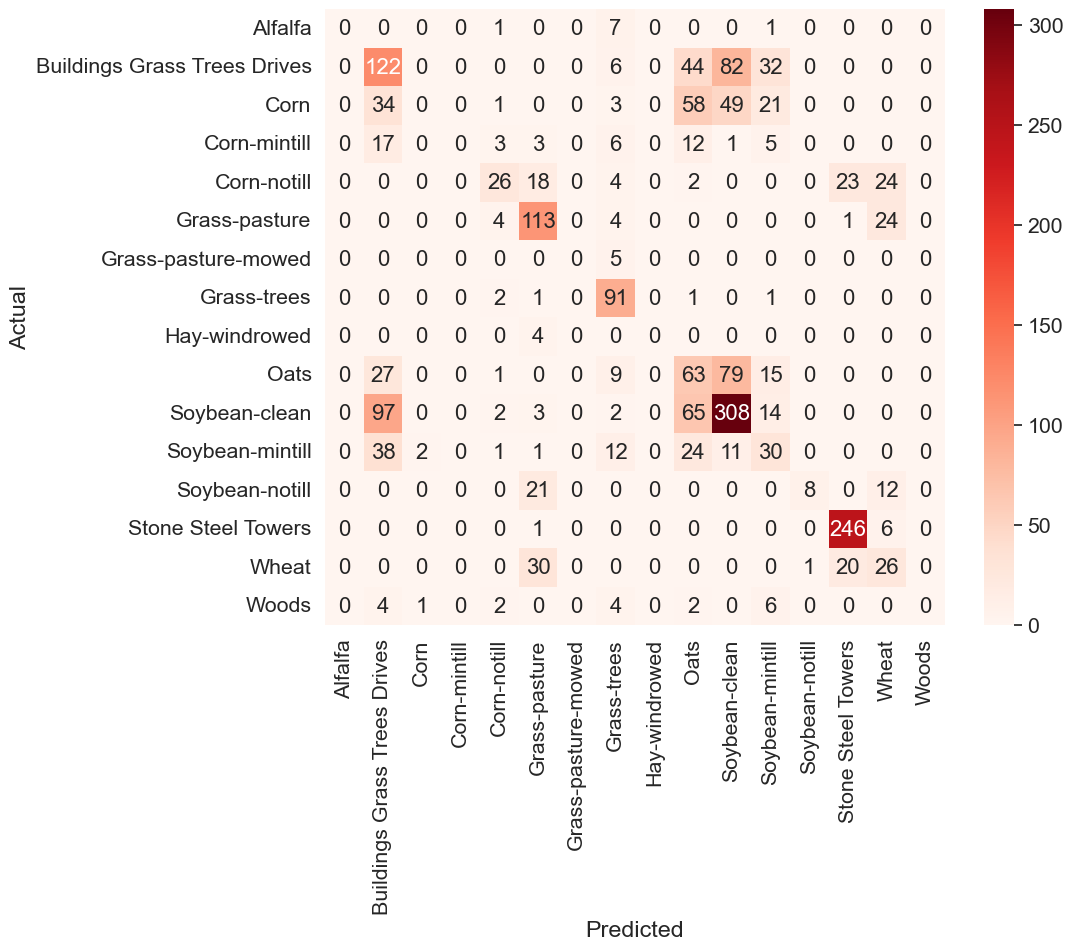

In [112]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [113]:
model.evaluate(X_test, y_test)

65/65 [==============================] - 1s 22ms/step - loss: 1.4040 - accuracy: 0.5039


[1.4040007591247559, 0.5039024353027344]

In [114]:
print(classification_report(y_test, y_pred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       0.00      0.00      0.00         9
                 Corn-notill       0.36      0.43      0.39       286
                Corn-mintill       0.00      0.00      0.00       166
                        Corn       0.00      0.00      0.00        47
               Grass-pasture       0.60      0.27      0.37        97
                 Grass-trees       0.58      0.77      0.66       146
         Grass-pasture-mowed       0.00      0.00      0.00         5
               Hay-windrowed       0.59      0.95      0.73        96
                        Oats       0.00      0.00      0.00         4
              Soybean-notill       0.23      0.32      0.27       194
             Soybean-mintill       0.58      0.63      0.60       491
               Soybean-clean       0.24      0.25      0.25       119
                       Wheat       0.89      0.20      0.32        41
                   

C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ksara\miniconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification Map

In [115]:
l=[]
for i in range(q.shape[0]):
    if q.iloc[i, -1] == 0:
        l.append(0)
    else:
        l.append(model.predict(q.iloc[i, :-1].values.reshape(1, -1), verbose=0))
#         l.append(model.predict(q.iloc[i, :-1].values.reshape(1, -1)))

l = [np.argmax(l[i]) for i in range(len(l))]

X shape: (145, 145, 200)
y shape: (145, 145)


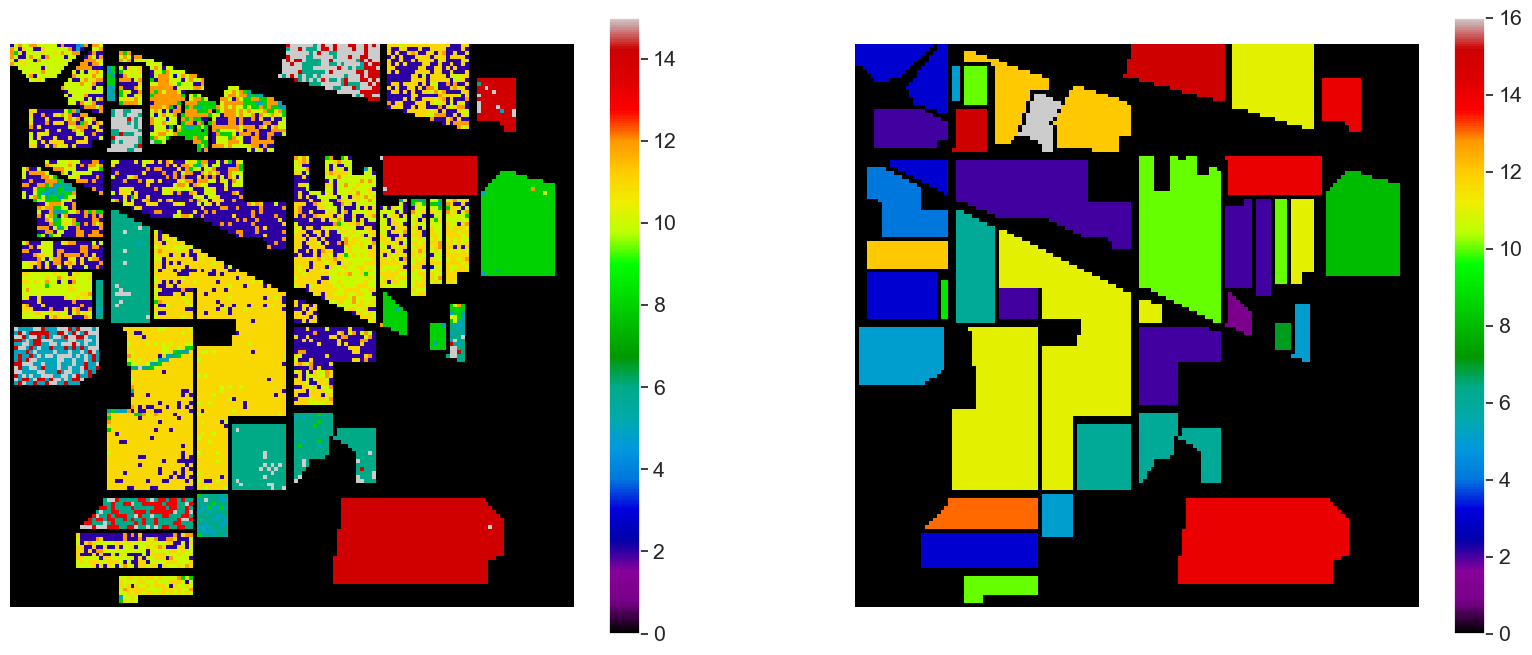

In [116]:
clmap = np.array(l).reshape(145, 145).astype('float')
X, y = read_HSI()

fig = plt.figure(figsize = (20, 8))

fig.add_subplot(1,2,1)
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

plt.show()